## Comparison of the oscillating basin analytical and xBeach solution

Author: WaveHello <br>
Last Modified: 06/24/2024 <br>

**Purpose**: <br>
Calculate the analytical solution for the oscillating basin example from the xBeach Non-Hydrostatic manual and compare to an xBeach model that has already been run.

**Link to the xBeach Non-Hydrostatic manual** <br>
[Link](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)

## Imports

In [10]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

In [11]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis


In [12]:
# Import library functions
sys.path.append(r"..\..\..\xBeach_Tutorial_Models")
from lib.oscillating_basin_funcs import (calc_wave_number, calc_linear_wave_freq,
                                        calc_surface_elevation, calc_U_velocity, calc_V_velocity,
                                        )
from lib.os_functions import (write_2d_arr_2_file)
from lib.general_functions import find_closest_value_index

In [13]:
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

### Load in the xBeach solution

In [14]:
# Xbeach model path
xBeach_model_path = r"2_oscillating_basin_nonh_2_layer"

xBeach_results = XBeachModelAnalysis(fname = "foo", 
                              model_path=xBeach_model_path)

xBeach_results.get_metadata()

### Get xBeach selected variables

In [15]:
# Currently this causes the selected variable and globaltime and few other things to be loaded
# Really it should just load what you ask for 
xBeach_U = xBeach_results.get_modeloutput("u")
xBeach_V = xBeach_results.get_modeloutput("v")

zs = xBeach_results.get_modeloutput("zs")
model_time = xBeach_results.var["globaltime"]

# Load the x grid
xBeach_results.load_grid()
x_grid = xBeach_results.grd["x"]
y_grid = xBeach_results.grd["y"]


# Using the x_grid twice because the y_grid is not stored from 0 to 100 
X, Y, T = np.meshgrid(x_grid[0], x_grid[0], model_time, indexing = "ij")

loading model output coordinates from file
loading variable u from file
loading variable v from file
loading variable zs from file


### Set the parameters for the Analytical model

In [16]:
L = 250 # Length, [m]
g = 9.81 # gravity, [m/s^2]

# wave numbers for the different directions
k_x = PI/L
k_y = PI/L

k = calc_wave_number(k_x, k_y)

relative_depth = 0.5 # k/H 

H = 250 # Water depth, [m]

omega = calc_linear_wave_freq(k, g, H) # Dispersion relation, angular velocity

wave_period = 2 * np.pi /omega

print("Still water depth (H): {:.5f}".format(H))
print("Directional wave numbers, x: {:.2f}, y: {:.2f} ".format(k_x, k_y))
print("Wave number magnitude: {:.3f}".format(k))
print("Depth: {:.3f}".format(H))
print("Angular Velocity: {:.3f}".format(omega))

Still water depth (H): 250.00000
Directional wave numbers, x: 0.01, y: 0.01 
Wave number magnitude: 0.018
Depth: 250.000
Angular Velocity: 0.417


### Calc the analytical solution values

In [17]:
# Set the initial water surface pertubation
eta_0 = 0.01

# Calc the surface elevation
eta = calc_surface_elevation(eta_0, k_x, k_y, X, Y, T, omega)

# Calc the x velocity
U = calc_U_velocity(eta_0, g, k_x, k_y, H, X, Y, T, omega)

# Calc the y velocity
V = calc_V_velocity(eta_0, g, k_x, k_y, H, X, Y, T, omega)

print("Model time: {}".format(model_time.max()))

Model time: 75.2


### Compare the analytical and the xBeach solution

In [18]:
# Get the x and y index that is closest to the selected point

point = np.array([50.0, 50.0])

x_index = find_closest_value_index(X[:,0, 0], point[0])
y_index = find_closest_value_index(Y[0, :, 0], point[1])

print("x-index: {}".format(x_index))
print("y-index: {}".format(y_index))

x-index: 16
y-index: 16


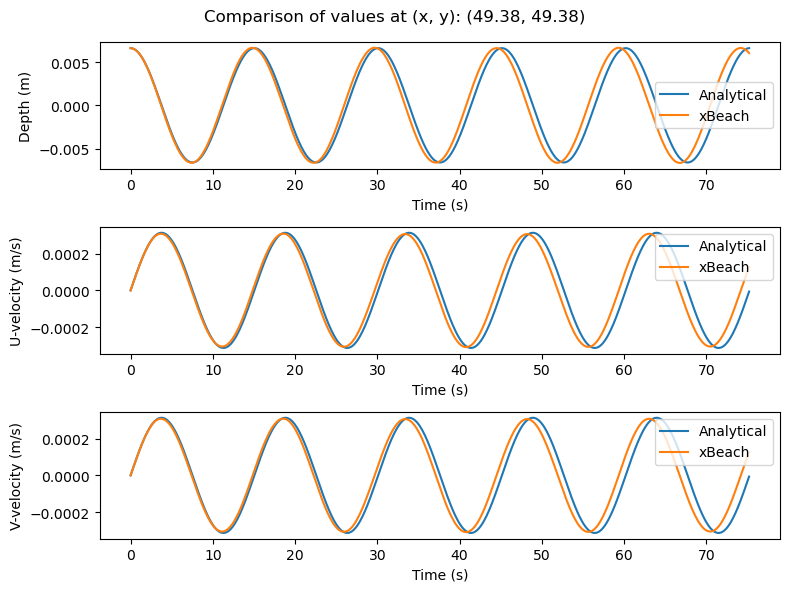

In [19]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6))

index = 0
# My variables are in this input order f = f(X, Y, T)
axs[index].plot(model_time, eta[x_index, y_index, :], label = "Analytical")

# xBeach variables are in this order f = f(T, Y, X)
axs[index].plot(model_time, zs[:, y_index, x_index], label = "xBeach")

# Format the plots
axs[index].legend()
axs[index].set_xlabel("Time (s)")
axs[index].set_ylabel("Depth (m)")


index = 1
# My variables are in this input order f = f(X, Y, T)
axs[index].plot(model_time, U[x_index, y_index, :], label = "Analytical")

# xBeach variables are in this order f = f(T, Y, X)
axs[index].plot(model_time, xBeach_U[:, y_index, x_index], label = "xBeach")

# Format the plots
axs[index].legend()
axs[index].set_xlabel("Time (s)")
axs[index].set_ylabel("U-velocity (m/s)")


index = 2
# My variables are in this input order f = f(X, Y, T)
axs[index].plot(model_time, V[x_index, y_index, :], label = "Analytical")

# xBeach variables are in this order f = f(T, Y, X)
axs[index].plot(model_time, xBeach_V[:, y_index, x_index], label = "xBeach")

# Format the plots
axs[index].legend()
axs[index].set_xlabel("Time (s)")
axs[index].set_ylabel("V-velocity (m/s)")

plt.suptitle("Comparison of values at (x, y): ({:.2f}, {:.2f})".format(x_grid[0, x_index], y_grid[y_index,0]))
plt.tight_layout()
plt.show()
